<a href="https://colab.research.google.com/github/AhmadMugiar/WEB_SCRAPPING_KP/blob/main/Analisis_Sentimen_Aplikasi_PosAgen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdown
!pip install Sastrawi
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import re
import string
import requests
from io import StringIO
import gdown
import nltk
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
data = pd.read_csv('/content/PosAja_Final.csv')
data

,reviewId,userName,rate,reviews_text,tanggal reviews,nama_aplikasi
0,cac942b3-2d1b-4d3d-aa85-1290b35a5a01,pengguna google,5,baik,2025-08-05,PosAja
1,a5f76849-26ea-47bb-b4a6-4471a6036ac3,pengguna google,1,paket saya dikirim ke orang lain tanpa konfirm...,2025-08-03,PosAja
2,9fc42b39-9103-4957-9866-0074b7ccafcc,pengguna google,2,niat hati bikin sim dikirim lewat pos eh malah...,2025-08-02,PosAja
3,284963a3-99db-42fb-9ebf-a3b56d3053bd,pengguna google,1,gila lemot banget pengirimannya,2025-08-01,PosAja
4,20610ea8-98c7-4ac0-b711-fce7e8d051f8,pengguna google,1,"aplikasi rusak. dimasukkan resi pada aplikasi,...",2025-07-30,PosAja
...,...,...,...,...,...,...
6960,1f948e9a-f8e1-4080-8153-41e0cb788b01,pengguna google,5,sangat memudahkan bagi para pelanggan pos dala...,2020-03-05,PosAja
6961,abbc0599-6620-46b0-b8a6-51067e5c2b65,pengguna google,5,perbaiki masalah pin nya orang gampang lupa ti...,2020-03-02,PosAja
6962,b57cb510-9bce-4f88-ad13-d5b9a477951e,pengguna google,5,kembali nya sang legenda...,2020-03-02,PosAja
6963,304143ba-b09a-4fc0-a613-f69ab0661e89,pengguna google,5,lebih maju pos indonesia,2020-03-02,PosAja


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6965 entries, 0 to 6964
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   reviewId         6965 non-null   object
 1   userName         6965 non-null   object
 2   rate             6965 non-null   int64 
 3   reviews_text     6965 non-null   object
 4   tanggal reviews  6965 non-null   object
 5   nama_aplikasi    6965 non-null   object
dtypes: int64(1), object(5)
memory usage: 326.6+ KB


In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
def cleaningText(text):
    text = re.sub(r'@\w+', '', text)  # Hapus mention
    text = re.sub(r'#\w+', '', text)  # Hapus hashtag
    text = re.sub(r'RT[\s]+', '', text)  # Hapus retweet
    text = re.sub(r'http\S+|www.\S+', '', text)  # Hapus link
    text = re.sub(r'\d+', '', text)  # Hapus angka
    text = re.sub(r'[{}]'.format(re.escape(string.punctuation)), ' ', text)  # Hapus tanda baca
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Menghapus tanda baca dan karakter selain huruf
    text = re.sub(r'(.)\1{1,}', r'\1', text)  # Menangani huruf berulang
    text = re.sub(r'\n', ' ', text)  # Ganti newline dengan spasi
    text = re.sub(r'\s+', ' ', text).strip()  # Menghapus spasi berlebih
    return text

In [ ]:
def casefoldingText(text):
    return text.lower()

In [ ]:
import pandas as pd

def load_slang_dictionary(filepath):
    slang_dict = {}
    try:
        # Read the Excel file
        df_slang = pd.read_excel(filepath)
        # Assuming the slang words are in the first column and the baku words in the second
        slang_dict = dict(zip(df_slang.iloc[:, 0], df_slang.iloc[:, 1]))
    except FileNotFoundError:
        print(f"Error: The file {filepath} was not found.")
    except Exception as e:
        print(f"An error occurred while reading the Excel file: {e}")
    return slang_dict

# Load the slang dictionary
slang_dict = load_slang_dictionary('kamuskatabaku.xlsx')

def normalize_slang(text, slang_dict):
    words = text.split()
    normalized_words = [slang_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)

In [ ]:
def tokenizingText(text):
    text = word_tokenize(text)
    return text

In [ ]:
import re
from collections import Counter

all_text = " ".join(data['reviews_text'].astype(str))
words = re.findall(r'\b[a-zA-Z]+\b', all_text.lower())
word_freq = Counter(words)
sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
slang_template = pd.DataFrame(sorted_words, columns=['slang_word', 'frequency'])
slang_template

,slang_word,frequency
0,pos,1879
1,di,1328
2,sangat,1250
3,dan,1174
4,aplikasi,1101
...,...,...
6642,pemulihannya,1
6643,chattingan,1
6644,nusa,1
6645,pokemon,1


In [ ]:
custom_stopwords = set(stopwords.words('indonesian')).union({'dan', 'atau', 'tetapi', 'yang', 'untuk', 'dari', 'ke', 'di', 'pada', 'oleh',
    'dengan', 'tanpa', 'sebagai', 'agar', 'sampai', 'selama', 'hingga', 'tentang',
    'antara', 'dalam', 'setiap', 'oleh', 'sebagai', 'karena', 'jadi','eh',
    'saya', 'aku', 'kamu', 'anda', 'dia', 'mereka', 'ini', 'itu', 'apa', 'siapa',
    'mana', 'bagaimana', 'kenapa', 'dimana', 'kapan', 'siapakah', 'yang', 'itu',
    'adalah', 'ada', 'sudah', 'belum', 'akan', 'bisa', 'harus', 'mungkin', 'lagi',
    'juga', 'hanya', 'sedikit', 'banyak', 'beberapa', 'lain', 'sendiri', 'sangat',
    'lebih', 'kurang', 'lagi', 'namun', 'tetap', 'masih', 'pada',
    'lah', 'mah', 'nih', 'dong', 'deh', 'sih', 'aja', 'gitu', 'ya', 'lo', 'lu', 'kok',
    'si', 'tau', 'kan', 'nya', 'dah', 'siap', 'cuma', 'aja', 'nih', 'gue', 'gua', 'lu', 'elo', 'loh',
    'ini', 'itu', 'sana', 'sini', 'sekali', 'semua', 'setiap', 'beberapa', 'lagi', 'baru', 'lama','aplikasi','Aplikasi','pos','pospay','bisa'})

In [ ]:
def filteringText(words):
    return [word for word in words if word not in custom_stopwords]

In [ ]:
def stemmingText(words):
    return [stemmer.stem(word) for word in words]

In [ ]:
def toSentence(list_words):
    return ' '.join(list_words)

In [ ]:
data['after_cleaning'] = data['reviews_text'].apply(cleaningText)

In [ ]:
data[['reviews_text', 'after_cleaning']]

,reviews_text,after_cleaning
0,baik,baik
1,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...
2,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...
3,gila lemot banget pengirimannya,gila lemot banget pengirimanya
4,"aplikasi rusak. dimasukkan resi pada aplikasi,...",aplikasi rusak dimasukan resi pada aplikasi da...
...,...,...
6960,sangat memudahkan bagi para pelanggan pos dala...,sangat memudahkan bagi para pelangan pos dalam...
6961,perbaiki masalah pin nya orang gampang lupa ti...,perbaiki masalah pin nya orang gampang lupa ti...
6962,kembali nya sang legenda...,kembali nya sang legenda
6963,lebih maju pos indonesia,lebih maju pos indonesia


In [ ]:
data['after_casefolding'] = data['after_cleaning'].apply(casefoldingText)

In [ ]:
data[['reviews_text', 'after_cleaning', 'after_casefolding']].head(10)

,reviews_text,after_cleaning,after_casefolding
0,baik,baik,baik
1,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...
2,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...
3,gila lemot banget pengirimannya,gila lemot banget pengirimanya,gila lemot banget pengirimanya
4,"aplikasi rusak. dimasukkan resi pada aplikasi,...",aplikasi rusak dimasukan resi pada aplikasi da...,aplikasi rusak dimasukan resi pada aplikasi da...
5,wa tolong dicantumkan per daerah biar jelas pe...,wa tolong dicantumkan per daerah biar jelas pe...,wa tolong dicantumkan per daerah biar jelas pe...
6,no wa tolong cantumkan biar jelas pemesanan ko...,no wa tolong cantumkan biar jelas pemesanan ko...,no wa tolong cantumkan biar jelas pemesanan ko...
7,ngirim pakett kok berhari hari. padahal udah d...,ngirim paket kok berhari hari padahal udah dek...,ngirim paket kok berhari hari padahal udah dek...
8,sangat membantu.. trima ksih 🙏,sangat membantu trima ksih,sangat membantu trima ksih
9,sangat bermanfaat. membantu sekali pedagang on...,sangat bermanfat membantu sekali pedagang onli...,sangat bermanfat membantu sekali pedagang onli...


In [ ]:
data['after_normalized'] = data['after_casefolding'].apply(lambda x: normalize_slang(x, slang_dict))

In [ ]:
data[['reviews_text', 'after_cleaning', 'after_casefolding', 'after_normalized']]
data.head(10)

,reviewId,userName,rate,reviews_text,tanggal reviews,nama_aplikasi,after_cleaning,after_casefolding,after_normalized
0,cac942b3-2d1b-4d3d-aa85-1290b35a5a01,pengguna google,5,baik,2025-08-05,PosAja,baik,baik,baik
1,a5f76849-26ea-47bb-b4a6-4471a6036ac3,pengguna google,1,paket saya dikirim ke orang lain tanpa konfirm...,2025-08-03,PosAja,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...
2,9fc42b39-9103-4957-9866-0074b7ccafcc,pengguna google,2,niat hati bikin sim dikirim lewat pos eh malah...,2025-08-02,PosAja,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...
3,284963a3-99db-42fb-9ebf-a3b56d3053bd,pengguna google,1,gila lemot banget pengirimannya,2025-08-01,PosAja,gila lemot banget pengirimanya,gila lemot banget pengirimanya,gila lemot banget pengirimanya
4,20610ea8-98c7-4ac0-b711-fce7e8d051f8,pengguna google,1,"aplikasi rusak. dimasukkan resi pada aplikasi,...",2025-07-30,PosAja,aplikasi rusak dimasukan resi pada aplikasi da...,aplikasi rusak dimasukan resi pada aplikasi da...,aplikasi rusak dimasukan resi pada aplikasi da...
5,0fd95dc4-7c68-4f37-8991-9ddaa16de3c5,pengguna google,1,wa tolong dicantumkan per daerah biar jelas pe...,2025-07-30,PosAja,wa tolong dicantumkan per daerah biar jelas pe...,wa tolong dicantumkan per daerah biar jelas pe...,wa tolong dicantumkan per daerah biar jelas pe...
6,c7236c51-777f-40a1-8c49-b07276df4590,pengguna google,1,no wa tolong cantumkan biar jelas pemesanan ko...,2025-07-30,PosAja,no wa tolong cantumkan biar jelas pemesanan ko...,no wa tolong cantumkan biar jelas pemesanan ko...,no wa tolong cantumkan biar jelas pemesanan ko...
7,4c3cb582-5e66-46a0-aa48-31a7a2577fd6,pengguna google,2,ngirim pakett kok berhari hari. padahal udah d...,2025-07-29,PosAja,ngirim paket kok berhari hari padahal udah dek...,ngirim paket kok berhari hari padahal udah dek...,mengirim paket kok berhari hari padahal sudah ...
8,2e9282b2-976f-4bfb-b49d-c3e94453f279,pengguna google,5,sangat membantu.. trima ksih 🙏,2025-07-28,PosAja,sangat membantu trima ksih,sangat membantu trima ksih,sangat membantu terima kasih
9,4eac9d6f-cfb6-4328-b7f4-0c1c79a056e7,pengguna google,5,sangat bermanfaat. membantu sekali pedagang on...,2025-07-27,PosAja,sangat bermanfat membantu sekali pedagang onli...,sangat bermanfat membantu sekali pedagang onli...,sangat bermanfat membantu sekali pedagang onli...


In [ ]:
data['after_tokenizing'] = data['after_normalized'].apply(tokenizingText)

In [ ]:
data[['reviews_text', 'after_cleaning', 'after_casefolding', 'after_normalized', 'after_tokenizing']].head(10)

,reviews_text,after_cleaning,after_casefolding,after_normalized,after_tokenizing
0,baik,baik,baik,baik,[baik]
1,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,"[paket, saya, dikirim, ke, orang, lain, tanpa,..."
2,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...,"[niat, hati, bikin, sim, dikirim, lewat, pos, ..."
3,gila lemot banget pengirimannya,gila lemot banget pengirimanya,gila lemot banget pengirimanya,gila lemot banget pengirimanya,"[gila, lemot, banget, pengirimanya]"
4,"aplikasi rusak. dimasukkan resi pada aplikasi,...",aplikasi rusak dimasukan resi pada aplikasi da...,aplikasi rusak dimasukan resi pada aplikasi da...,aplikasi rusak dimasukan resi pada aplikasi da...,"[aplikasi, rusak, dimasukan, resi, pada, aplik..."
5,wa tolong dicantumkan per daerah biar jelas pe...,wa tolong dicantumkan per daerah biar jelas pe...,wa tolong dicantumkan per daerah biar jelas pe...,wa tolong dicantumkan per daerah biar jelas pe...,"[wa, tolong, dicantumkan, per, daerah, biar, j..."
6,no wa tolong cantumkan biar jelas pemesanan ko...,no wa tolong cantumkan biar jelas pemesanan ko...,no wa tolong cantumkan biar jelas pemesanan ko...,no wa tolong cantumkan biar jelas pemesanan ko...,"[no, wa, tolong, cantumkan, biar, jelas, pemes..."
7,ngirim pakett kok berhari hari. padahal udah d...,ngirim paket kok berhari hari padahal udah dek...,ngirim paket kok berhari hari padahal udah dek...,mengirim paket kok berhari hari padahal sudah ...,"[mengirim, paket, kok, berhari, hari, padahal,..."
8,sangat membantu.. trima ksih 🙏,sangat membantu trima ksih,sangat membantu trima ksih,sangat membantu terima kasih,"[sangat, membantu, terima, kasih]"
9,sangat bermanfaat. membantu sekali pedagang on...,sangat bermanfat membantu sekali pedagang onli...,sangat bermanfat membantu sekali pedagang onli...,sangat bermanfat membantu sekali pedagang onli...,"[sangat, bermanfat, membantu, sekali, pedagang..."


In [ ]:
data['after_filtering'] = data['after_tokenizing'].apply(filteringText)

In [ ]:
data[['reviews_text', 'after_cleaning', 'after_casefolding', 'after_normalized', 'after_tokenizing', 'after_filtering']].head(10)

,reviews_text,after_cleaning,after_casefolding,after_normalized,after_tokenizing,after_filtering
0,baik,baik,baik,baik,[baik],[]
1,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,"[paket, saya, dikirim, ke, orang, lain, tanpa,...","[paket, dikirim, orang, konfirmasi, status, pa..."
2,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...,"[niat, hati, bikin, sim, dikirim, lewat, pos, ...","[niat, hati, bikin, sim, dikirim, zonk, harusk..."
3,gila lemot banget pengirimannya,gila lemot banget pengirimanya,gila lemot banget pengirimanya,gila lemot banget pengirimanya,"[gila, lemot, banget, pengirimanya]","[gila, lemot, banget, pengirimanya]"
4,"aplikasi rusak. dimasukkan resi pada aplikasi,...",aplikasi rusak dimasukan resi pada aplikasi da...,aplikasi rusak dimasukan resi pada aplikasi da...,aplikasi rusak dimasukan resi pada aplikasi da...,"[aplikasi, rusak, dimasukan, resi, pada, aplik...","[rusak, dimasukan, resi, data, valid, lacak, m..."
5,wa tolong dicantumkan per daerah biar jelas pe...,wa tolong dicantumkan per daerah biar jelas pe...,wa tolong dicantumkan per daerah biar jelas pe...,wa tolong dicantumkan per daerah biar jelas pe...,"[wa, tolong, dicantumkan, per, daerah, biar, j...","[wa, tolong, dicantumkan, daerah, biar, pemesa..."
6,no wa tolong cantumkan biar jelas pemesanan ko...,no wa tolong cantumkan biar jelas pemesanan ko...,no wa tolong cantumkan biar jelas pemesanan ko...,no wa tolong cantumkan biar jelas pemesanan ko...,"[no, wa, tolong, cantumkan, biar, jelas, pemes...","[no, wa, tolong, cantumkan, biar, pemesanan, k..."
7,ngirim pakett kok berhari hari. padahal udah d...,ngirim paket kok berhari hari padahal udah dek...,ngirim paket kok berhari hari padahal udah dek...,mengirim paket kok berhari hari padahal sudah ...,"[mengirim, paket, kok, berhari, hari, padahal,...","[mengirim, paket, berhari, banget, tinggal, an..."
8,sangat membantu.. trima ksih 🙏,sangat membantu trima ksih,sangat membantu trima ksih,sangat membantu terima kasih,"[sangat, membantu, terima, kasih]","[membantu, terima, kasih]"
9,sangat bermanfaat. membantu sekali pedagang on...,sangat bermanfat membantu sekali pedagang onli...,sangat bermanfat membantu sekali pedagang onli...,sangat bermanfat membantu sekali pedagang onli...,"[sangat, bermanfat, membantu, sekali, pedagang...","[bermanfat, membantu, pedagang, online, pengir..."


In [ ]:
data['after_stemming'] = data['after_filtering'].apply(stemmingText)

In [ ]:
data[['reviews_text', 'after_cleaning', 'after_casefolding', 'after_normalized', 'after_tokenizing', 'after_filtering', 'after_stemming']].head(10)

,reviews_text,after_cleaning,after_casefolding,after_normalized,after_tokenizing,after_filtering,after_stemming
0,baik,baik,baik,baik,[baik],[],[]
1,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,"[paket, saya, dikirim, ke, orang, lain, tanpa,...","[paket, dikirim, orang, konfirmasi, status, pa...","[paket, kirim, orang, konfirmasi, status, pake..."
2,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...,"[niat, hati, bikin, sim, dikirim, lewat, pos, ...","[niat, hati, bikin, sim, dikirim, zonk, harusk...","[niat, hati, bikin, sim, kirim, zonk, harus, t..."
3,gila lemot banget pengirimannya,gila lemot banget pengirimanya,gila lemot banget pengirimanya,gila lemot banget pengirimanya,"[gila, lemot, banget, pengirimanya]","[gila, lemot, banget, pengirimanya]","[gila, lot, banget, pengirimanya]"
4,"aplikasi rusak. dimasukkan resi pada aplikasi,...",aplikasi rusak dimasukan resi pada aplikasi da...,aplikasi rusak dimasukan resi pada aplikasi da...,aplikasi rusak dimasukan resi pada aplikasi da...,"[aplikasi, rusak, dimasukan, resi, pada, aplik...","[rusak, dimasukan, resi, data, valid, lacak, m...","[rusak, masuk, resi, data, valid, lacak, mengu..."
5,wa tolong dicantumkan per daerah biar jelas pe...,wa tolong dicantumkan per daerah biar jelas pe...,wa tolong dicantumkan per daerah biar jelas pe...,wa tolong dicantumkan per daerah biar jelas pe...,"[wa, tolong, dicantumkan, per, daerah, biar, j...","[wa, tolong, dicantumkan, daerah, biar, pemesa...","[wa, tolong, cantum, daerah, biar, mesan, kons..."
6,no wa tolong cantumkan biar jelas pemesanan ko...,no wa tolong cantumkan biar jelas pemesanan ko...,no wa tolong cantumkan biar jelas pemesanan ko...,no wa tolong cantumkan biar jelas pemesanan ko...,"[no, wa, tolong, cantumkan, biar, jelas, pemes...","[no, wa, tolong, cantumkan, biar, pemesanan, k...","[no, wa, tolong, cantum, biar, mesan, konsumen..."
7,ngirim pakett kok berhari hari. padahal udah d...,ngirim paket kok berhari hari padahal udah dek...,ngirim paket kok berhari hari padahal udah dek...,mengirim paket kok berhari hari padahal sudah ...,"[mengirim, paket, kok, berhari, hari, padahal,...","[mengirim, paket, berhari, banget, tinggal, an...","[kirim, paket, hari, banget, tinggal, anter, a..."
8,sangat membantu.. trima ksih 🙏,sangat membantu trima ksih,sangat membantu trima ksih,sangat membantu terima kasih,"[sangat, membantu, terima, kasih]","[membantu, terima, kasih]","[bantu, terima, kasih]"
9,sangat bermanfaat. membantu sekali pedagang on...,sangat bermanfat membantu sekali pedagang onli...,sangat bermanfat membantu sekali pedagang onli...,sangat bermanfat membantu sekali pedagang onli...,"[sangat, bermanfat, membantu, sekali, pedagang...","[bermanfat, membantu, pedagang, online, pengir...","[bermanfat, bantu, dagang, online, kirim, indo..."


In [ ]:
data['final_sentence'] = data['after_stemming'].apply(toSentence)

In [ ]:
data[['reviews_text', 'after_cleaning', 'after_casefolding', 'after_normalized', 'after_tokenizing', 'after_filtering', 'after_stemming', 'final_sentence']].head(10)

,reviews_text,after_cleaning,after_casefolding,after_normalized,after_tokenizing,after_filtering,after_stemming,final_sentence
0,baik,baik,baik,baik,[baik],[],[],
1,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,"[paket, saya, dikirim, ke, orang, lain, tanpa,...","[paket, dikirim, orang, konfirmasi, status, pa...","[paket, kirim, orang, konfirmasi, status, pake...",paket kirim orang konfirmasi status paket teri...
2,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...,"[niat, hati, bikin, sim, dikirim, lewat, pos, ...","[niat, hati, bikin, sim, dikirim, zonk, harusk...","[niat, hati, bikin, sim, kirim, zonk, harus, t...",niat hati bikin sim kirim zonk harus tanggal s...
3,gila lemot banget pengirimannya,gila lemot banget pengirimanya,gila lemot banget pengirimanya,gila lemot banget pengirimanya,"[gila, lemot, banget, pengirimanya]","[gila, lemot, banget, pengirimanya]","[gila, lot, banget, pengirimanya]",gila lot banget pengirimanya
4,"aplikasi rusak. dimasukkan resi pada aplikasi,...",aplikasi rusak dimasukan resi pada aplikasi da...,aplikasi rusak dimasukan resi pada aplikasi da...,aplikasi rusak dimasukan resi pada aplikasi da...,"[aplikasi, rusak, dimasukan, resi, pada, aplik...","[rusak, dimasukan, resi, data, valid, lacak, m...","[rusak, masuk, resi, data, valid, lacak, mengu...",rusak masuk resi data valid lacak mengunakan w...
5,wa tolong dicantumkan per daerah biar jelas pe...,wa tolong dicantumkan per daerah biar jelas pe...,wa tolong dicantumkan per daerah biar jelas pe...,wa tolong dicantumkan per daerah biar jelas pe...,"[wa, tolong, dicantumkan, per, daerah, biar, j...","[wa, tolong, dicantumkan, daerah, biar, pemesa...","[wa, tolong, cantum, daerah, biar, mesan, kons...",wa tolong cantum daerah biar mesan konsumen ru...
6,no wa tolong cantumkan biar jelas pemesanan ko...,no wa tolong cantumkan biar jelas pemesanan ko...,no wa tolong cantumkan biar jelas pemesanan ko...,no wa tolong cantumkan biar jelas pemesanan ko...,"[no, wa, tolong, cantumkan, biar, jelas, pemes...","[no, wa, tolong, cantumkan, biar, pemesanan, k...","[no, wa, tolong, cantum, biar, mesan, konsumen...",no wa tolong cantum biar mesan konsumen rugi b...
7,ngirim pakett kok berhari hari. padahal udah d...,ngirim paket kok berhari hari padahal udah dek...,ngirim paket kok berhari hari padahal udah dek...,mengirim paket kok berhari hari padahal sudah ...,"[mengirim, paket, kok, berhari, hari, padahal,...","[mengirim, paket, berhari, banget, tinggal, an...","[kirim, paket, hari, banget, tinggal, anter, a...",kirim paket hari banget tinggal anter alamat t...
8,sangat membantu.. trima ksih 🙏,sangat membantu trima ksih,sangat membantu trima ksih,sangat membantu terima kasih,"[sangat, membantu, terima, kasih]","[membantu, terima, kasih]","[bantu, terima, kasih]",bantu terima kasih
9,sangat bermanfaat. membantu sekali pedagang on...,sangat bermanfat membantu sekali pedagang onli...,sangat bermanfat membantu sekali pedagang onli...,sangat bermanfat membantu sekali pedagang onli...,"[sangat, bermanfat, membantu, sekali, pedagang...","[bermanfat, membantu, pedagang, online, pengir...","[bermanfat, bantu, dagang, online, kirim, indo...",bermanfat bantu dagang online kirim indonesia ...


In [ ]:
!gdown --id 1hOYYAYMGSd0JoqDcBxjhtVm6koOnk-KQ

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1hOYYAYMGSd0JoqDcBxjhtVm6koOnk-KQ
To: /content/lexicon_positive_ver1.csv
100% 41.4k/41.4k [00:00<00:00, 49.0MB/s]


In [ ]:
!gdown --id 1HVydsM-fsSdIugnuSF6L9-Ai4UnRB_ju

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1HVydsM-fsSdIugnuSF6L9-Ai4UnRB_ju
To: /content/lexicon_negative_ver1.csv
100% 82.8k/82.8k [00:00<00:00, 48.6MB/s]


<Axes: xlabel='rate'>

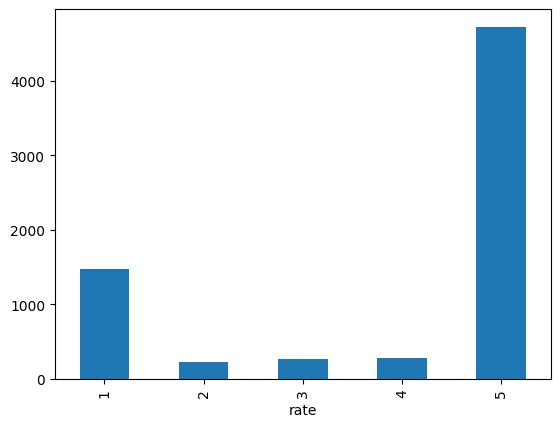

In [ ]:
data["rate"].value_counts().sort_index().plot(kind="bar")

In [ ]:
lexicon_positive = dict()
import csv
with open('lexicon_positive_ver1.csv', 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  for row in reader:
    lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
import csv
with open('lexicon_negative_ver1.csv', 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  for row in reader:
    lexicon_negative[row[0]] = int(row[1])

In [ ]:
def sentimen_lexicon_indo(text):
  score = 0
  for word_pos in text:
    if (word_pos in lexicon_positive):
      score = score + lexicon_positive[word_pos]
  for word_neg in text:
    if (word_neg in lexicon_negative):
      score = score + lexicon_negative[word_neg]
  polarity=''
  if (score > 0):
    polarity = 'positif'
  elif (score < 0):
    polarity = 'negatif'
  else:
    polarity = 'netral'

  return score, polarity

In [ ]:
string = "wahhh gilaa aplikasinya bagus banget fiturnya ok banget suka keren bngt pos skrng"
string = string.split()
hasil = sentimen_lexicon_indo(string)
hasil

(6, 'positif')

In [ ]:
data['tokenized'] = data['final_sentence'].apply(lambda x: x.split())

In [ ]:
data[['score', 'sentiment']] = data['tokenized'].apply(lambda x: pd.Series(sentimen_lexicon_indo(x)))

In [ ]:
data

,reviewId,userName,rate,reviews_text,tanggal reviews,nama_aplikasi,after_cleaning,after_casefolding,after_normalized,after_tokenizing,after_filtering,after_stemming,final_sentence,tokenized,score,sentiment
0,cac942b3-2d1b-4d3d-aa85-1290b35a5a01,pengguna google,5,baik,2025-08-05,PosAja,baik,baik,baik,[baik],[],[],,[],0,netral
1,a5f76849-26ea-47bb-b4a6-4471a6036ac3,pengguna google,1,paket saya dikirim ke orang lain tanpa konfirm...,2025-08-03,PosAja,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,"[paket, saya, dikirim, ke, orang, lain, tanpa,...","[paket, dikirim, orang, konfirmasi, status, pa...","[paket, kirim, orang, konfirmasi, status, pake...",paket kirim orang konfirmasi status paket teri...,"[paket, kirim, orang, konfirmasi, status, pake...",16,positif
2,9fc42b39-9103-4957-9866-0074b7ccafcc,pengguna google,2,niat hati bikin sim dikirim lewat pos eh malah...,2025-08-02,PosAja,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...,"[niat, hati, bikin, sim, dikirim, lewat, pos, ...","[niat, hati, bikin, sim, dikirim, zonk, harusk...","[niat, hati, bikin, sim, kirim, zonk, harus, t...",niat hati bikin sim kirim zonk harus tanggal s...,"[niat, hati, bikin, sim, kirim, zonk, harus, t...",-23,negatif
3,284963a3-99db-42fb-9ebf-a3b56d3053bd,pengguna google,1,gila lemot banget pengirimannya,2025-08-01,PosAja,gila lemot banget pengirimanya,gila lemot banget pengirimanya,gila lemot banget pengirimanya,"[gila, lemot, banget, pengirimanya]","[gila, lemot, banget, pengirimanya]","[gila, lot, banget, pengirimanya]",gila lot banget pengirimanya,"[gila, lot, banget, pengirimanya]",-6,negatif
4,20610ea8-98c7-4ac0-b711-fce7e8d051f8,pengguna google,1,"aplikasi rusak. dimasukkan resi pada aplikasi,...",2025-07-30,PosAja,aplikasi rusak dimasukan resi pada aplikasi da...,aplikasi rusak dimasukan resi pada aplikasi da...,aplikasi rusak dimasukan resi pada aplikasi da...,"[aplikasi, rusak, dimasukan, resi, pada, aplik...","[rusak, dimasukan, resi, data, valid, lacak, m...","[rusak, masuk, resi, data, valid, lacak, mengu...",rusak masuk resi data valid lacak mengunakan w...,"[rusak, masuk, resi, data, valid, lacak, mengu...",-7,negatif
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6960,1f948e9a-f8e1-4080-8153-41e0cb788b01,pengguna google,5,sangat memudahkan bagi para pelanggan pos dala...,2020-03-05,PosAja,sangat memudahkan bagi para pelangan pos dalam...,sangat memudahkan bagi para pelangan pos dalam...,sangat memudahkan bagi para pelangan pos dalam...,"[sangat, memudahkan, bagi, para, pelangan, pos...","[memudahkan, pelangan, bertransaksi, fitur, pi...","[mudah, pelang, transaksi, fitur, pickup, cape...",mudah pelang transaksi fitur pickup capek kant...,"[mudah, pelang, transaksi, fitur, pickup, cape...",10,positif
6961,abbc0599-6620-46b0-b8a6-51067e5c2b65,pengguna google,5,perbaiki masalah pin nya orang gampang lupa ti...,2020-03-02,PosAja,perbaiki masalah pin nya orang gampang lupa ti...,perbaiki masalah pin nya orang gampang lupa ti...,perbaiki masalah pin ya orang gampang lupa tin...,"[perbaiki, masalah, pin, ya, orang, gampang, l...","[perbaiki, pin, orang, gampang, lupa, tingkatkan]","[baik, pin, orang, gampang, lupa, tingkat]",baik pin orang gampang lupa tingkat,"[baik, pin, orang, gampang, lupa, tingkat]",2,positif
6962,b57cb510-9bce-4f88-ad13-d5b9a477951e,pengguna google,5,kembali nya sang legenda...,2020-03-02,PosAja,kembali nya sang legenda,kembali nya sang legenda,kembali ya sang legenda,"[kembali, ya, sang, legenda]","[sang, legenda]","[sang, legenda]",sang legenda,"[sang, legenda]",0,netral
6963,304143ba-b09a-4fc0-a613-f69ab0661e89,pengguna google,5,lebih maju pos indonesia,2020-03-02,PosAja,lebih maju pos indonesia,lebih maju pos indonesia,lebih maju pos indonesia,"[lebih, maju, pos, indonesia]","[maju, indonesia]",

/tmp/ipython-input-659642902.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  sentimen_data = pd.value_counts(data['sentiment'], sort=True)


<function matplotlib.pyplot.show(close=None, block=None)>

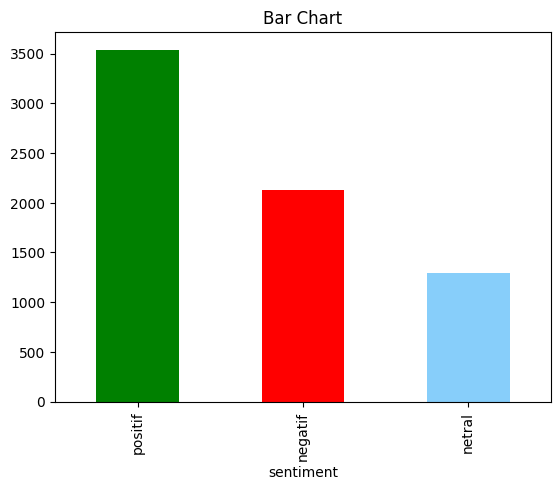

In [ ]:
sentimen_data = pd.value_counts(data['sentiment'], sort=True)
sentimen_data.plot(kind='bar', color=['green','red','lightskyblue'])
plt.title("Bar Chart")
plt.show

In [ ]:
results = data['tokenized'].apply(sentimen_lexicon_indo)
results = list(zip(*results))
data['polarity_score'] = results[0]
data['polarity'] = results[1]
print(data['polarity'].value_counts())

polarity
positif    3540
negatif    2128
netral     1297
Name: count, dtype: int64


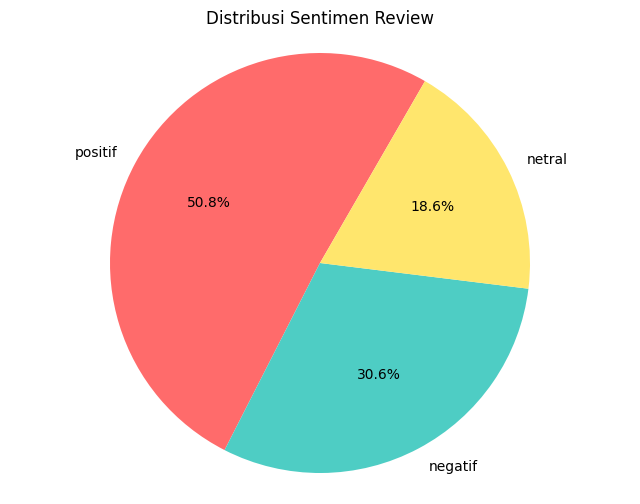

In [ ]:
# Hitung jumlah masing-masing sentimen
sentiment_counts = data['polarity'].value_counts()

# Label dan nilai
labels = sentiment_counts.index
sizes = sentiment_counts.values
colors = ['#FF6B6B', '#4ECDC4', '#FFE66D']

# Buat pie chart
plt.figure(figsize=(8,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=60, colors=colors)
plt.title('Distribusi Sentimen Review')
plt.axis('equal')  # Membuat pie-nya jadi lingkaran sempurna
plt.show()

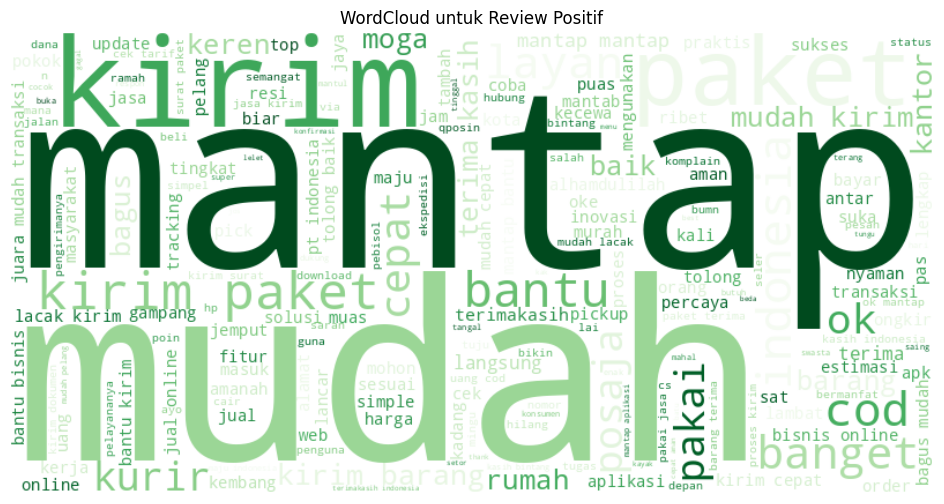

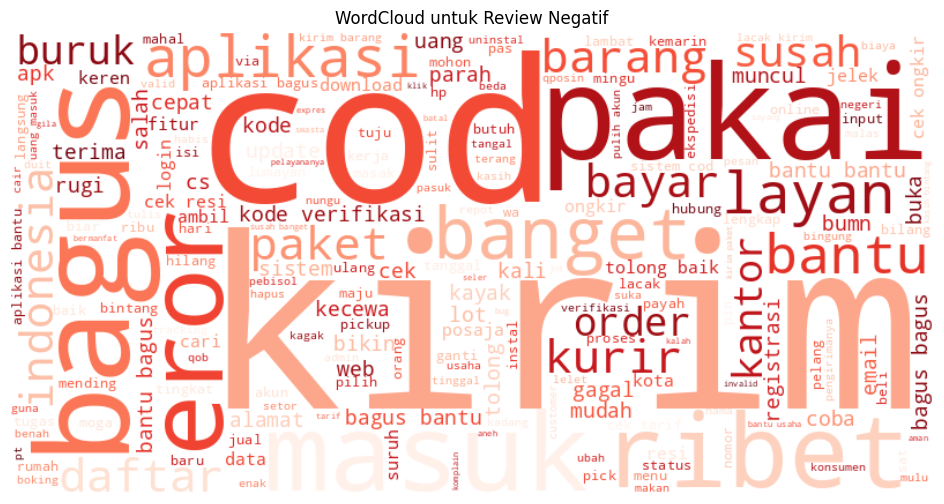

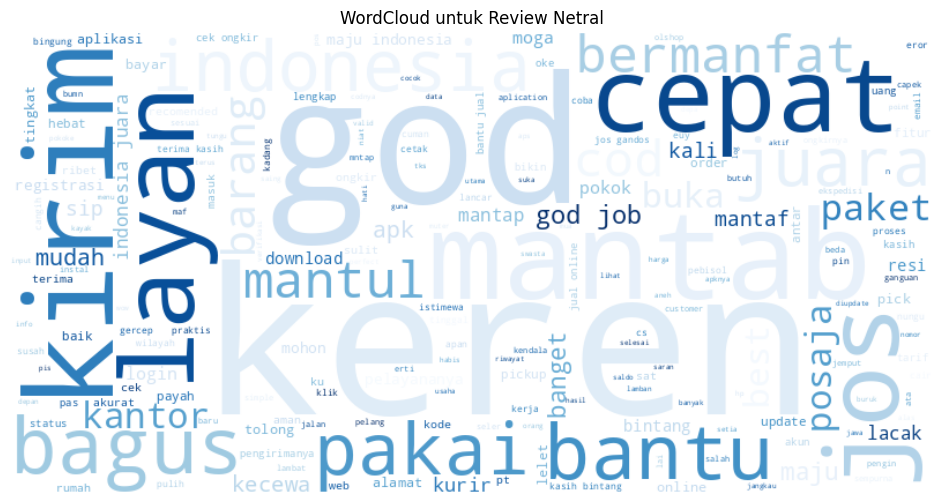

In [ ]:
# Fungsi untuk membuat dan menampilkan WordCloud
def tampilkan_wordcloud(text, title, colormap):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=colormap).generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Gabungkan semua teks dari tiap sentimen
positif_text = ' '.join(data[data['polarity'] == 'positif']['final_sentence'])
negatif_text = ' '.join(data[data['polarity'] == 'negatif']['final_sentence'])
netral_text  = ' '.join(data[data['polarity'] == 'netral']['final_sentence'])

# Tampilkan WordCloud
tampilkan_wordcloud(positif_text, 'WordCloud untuk Review Positif', 'Greens')
tampilkan_wordcloud(negatif_text, 'WordCloud untuk Review Negatif', 'Reds')
tampilkan_wordcloud(netral_text,  'WordCloud untuk Review Netral',  'Blues')

In [ ]:
X = data['final_sentence']
y = data['polarity']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

print(X_train.shape)
print(X_test.shape)

(5572,)
(1393,)


In [ ]:
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

In [ ]:
X_train_array = X_train.toarray()
X_test_array = X_test.toarray()

In [ ]:
# Membuat objek model SVM
svm_model = SVC(C=1, kernel='rbf')

# Melatih model SVM pada data pelatihan
svm_model.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_svm = svm_model.predict(X_train.toarray())
y_pred_test_svm = svm_model.predict(X_test.toarray())

# Evaluasi akurasi model SVM
accuracy_train_svm = accuracy_score(y_pred_train_svm, y_train)
accuracy_test_svm = accuracy_score(y_pred_test_svm, y_test)

# Menampilkan akurasi
print('SVM - accuracy_train:', accuracy_train_svm)
print('SVM - accuracy_test:', accuracy_test_svm)

SVM - accuracy_train: 0.9860014357501795
SVM - accuracy_test: 0.9045226130653267


In [ ]:
# Menampilkan classification report
print('\nClassification Report SVM (Test Data):')
print(classification_report(y_test, y_pred_test_svm))


Classification Report SVM (Test Data):
              precision    recall  f1-score   support

     negatif       0.87      0.91      0.89       439
      netral       0.95      0.74      0.83       259
     positif       0.91      0.96      0.94       695

    accuracy                           0.90      1393
   macro avg       0.91      0.87      0.89      1393
weighted avg       0.91      0.90      0.90      1393



In [ ]:
# Membuat objek model Random Forest
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)

# Melatih model Random Forest pada data pelatihan
rf_model.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf = rf_model.predict(X_train.toarray())
y_pred_test_rf = rf_model.predict(X_test.toarray())

# Evaluasi akurasi model Random Forest
accuracy_train_rf = accuracy_score(y_train, y_pred_train_rf)
accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)

# Menampilkan akurasi
print('Random Forest - accuracy_train:', accuracy_train_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)

Random Forest - accuracy_train: 0.9998205312275664
Random Forest - accuracy_test: 0.8880114860014358


In [ ]:
# Menampilkan classification report
print('\nClassification Report Random Forest (Test Data):')
print(classification_report(y_test, y_pred_test_rf))


Classification Report Random Forest (Test Data):
              precision    recall  f1-score   support

     negatif       0.90      0.84      0.87       439
      netral       0.84      0.86      0.85       259
     positif       0.90      0.93      0.91       695

    accuracy                           0.89      1393
   macro avg       0.88      0.88      0.88      1393
weighted avg       0.89      0.89      0.89      1393



In [ ]:
X = data['final_sentence']
y = data['polarity']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

print(X_train.shape)
print(X_test.shape)

(5572,)
(1393,)


In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

maxlen = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

In [ ]:
# Label Encoding

encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)

y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

In [ ]:
# Custom Callback
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)

In [ ]:
# modeling dengan lstm
model = Sequential([
        Embedding(input_dim=10000, output_dim=128, input_length=maxlen),
        Bidirectional(LSTM(128, return_sequences=False)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_pad, y_train_cat, epochs=15, batch_size=32,
                        validation_data=(X_test_pad, y_test_cat), callbacks=[early_stop, reduce_lr])

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


175/175 ━━━━━━━━━━━━━━━━━━━━ 64s 333ms/step - accuracy: 0.5765 - loss: 0.9169 - val_accuracy: 0.8995 - val_loss: 0.3181 - learning_rate: 0.0010
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 81s 329ms/step - accuracy: 0.9044 - loss: 0.3037 - val_accuracy: 0.9160 - val_loss: 0.2355 - learning_rate: 0.0010
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 57s 324ms/step - accuracy: 0.9507 - loss: 0.1564 - val_accuracy: 0.9203 - val_loss: 0.2622 - learning_rate: 0.0010
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 84s 336ms/step - accuracy: 0.9708 - loss: 0.0889 - val_accuracy: 0.9167 - val_loss: 0.2605 - learning_rate: 0.0010
Epoch 5/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 81s 332ms/step - accuracy: 0.9763 - loss: 0.0690 - val_accuracy: 0.9210 - val_loss: 0.2924 - learning_rate: 0.0010
Epoch 6/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 82s 331ms/step - accuracy: 0.9743 - loss: 0.0760 - val_accuracy: 0.9139 - val_loss: 0.3448 - learning_rate: 0.0010
Epoch 7/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.9828 - loss: 

In [ ]:
# Evaluasi akurasi pada data training
train_pred_probs = model.predict(X_train_pad)
train_pred = np.argmax(train_pred_probs, axis=1)
train_true = np.argmax(y_train_cat, axis=1)
accuracy_train_lstm = accuracy_score(train_true, train_pred)

# Evaluasi akurasi pada data testing
test_pred_probs = model.predict(X_test_pad)
test_pred = np.argmax(test_pred_probs, axis=1)
test_true = np.argmax(y_test_cat, axis=1)
accuracy_test_lstm = accuracy_score(test_true, test_pred)

# Menampilkan hasil evaluasi
print('LSTM - accuracy_train:', accuracy_train_lstm)
print('LSTM - accuracy_test:', accuracy_test_lstm)

175/175 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step
LSTM - accuracy_train: 0.9565685570710696
LSTM - accuracy_test: 0.9160086145010768


In [ ]:
# Classification report
print("\nClassification Report Bidirectional LSTM (Test Data):")
print(classification_report(test_true, test_pred, target_names=encoder.classes_))